# Exercise 2 | TKO_7092 Evaluation of Machine Learning Methods 2026
## deadline: 11.2.2026 - 23:59

Regarding any questions about this exercise, please contact course assistant Jonne Pohjankukka (jjepoh@utu.fi)

********************************************

Student name: Robert Siipola

Student number: 2508568

Student email: robertsiipola@gmail.com

********************************************

## Water permeability prediction in forestry <br>

In this task, the client wants you to estimate the spatial prediction performance of K-nearest neighbor regression model with K=9 (9NN), using spatial leave-one-out cross-validation (i.e. SKCV, with number of folds == number of data points). The client wants you to use the C-index as the performance measure.  

In other words, the client wants you to answer the question: "What happens to the prediction performance of water permeability using 9-nearest neighbor regression model, when the geographical distance between known data and unknown data increases?".

In this task, you have three data files available (with 1691 data points): 

- input.csv, contains the 75 predictor features. 
- output.csv, contains the water permebility values. 
- coordinates.csv, contains the corresponding geographical coordinate locations of the data points. The unit of the coordinates is metre, and you can use Euclidean distance to calculate distances between the coordinate points. 

Implement the following tasks to complete this exercise:

********************************************

#### 1. Z-score standardize the predictor features (input.csv). 

#### 2. Perform spatial leave-one-out cross-validation with 9NN model for the provided data set (refer to the video lectures 3.1.3 and 3.1.4 in 'Evaluating spatial models with spatial cross-validation' for help). Estimate the water permeability prediction performance (using 9NN model and C-index) with the following distance parameter values: d = 0, 20, 40, ..., 300 (that is, 20 meter intervals from 0m to 300m). 

#### 3. When you have calculated the C-index performance measure for each value of d, visualize the results with the C-index (y-axis) as a function of d (x-axis).

********************************************

Your .ipynb-file must include the following: 

- Your own implementation of the spatial leave-one-out cross-validation for the current task. You can use third-party libraries (e.g. Scikit-learn) if you want for implementing e.g. the 9-nearest neighbor. Also, try to follow good programming practices and add comments to relevant parts of your code explaining what you are doing and why.

- Plot of the graph C-index vs. distance parameter value.

### Other guidelines on the return:

- Return your solution as a Jupyter Notebook (.ipynb) and as a PDF file generated from it. Please, add your full name to the file name.
- Make sure that the code is runnable as is.
- If AI was used, please explain at the end of the notebook, in the "AI usage disclaimer" section, how and in which parts it was applied.
- The exercise will be graded as pass/fail.
- Submit to moodle your solution on **Wednesday 11th of February** at the latest.
  
<b>Please be aware that you are required to submit your individual solution.<br> 
Submissions with identical or similar code will result in a failure for the exercise.</b>


<br><br><br>
-- START IMPLEMENTING YOUR EXERCISE AFTER THIS LINE --
<br><br><br>

### Import necessary libraries

In [18]:
# In this cell, import all the libraries that you need. For example: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from scipy.spatial import distance_matrix
sns.set_style("darkgrid")

### Read in the datasets

In [ ]:
# In this cell, read the files input.csv, output.csv and coordinates.csv.
# Print out the dataset dimesions (i.e. number of rows and columns).

coordinates_path = "../data/excercise-2/coordinates.csv"
coordinates_df = pd.read_csv(coordinates_path)

input_path = "../data/excercise-2/input.csv"
input_df = pd.read_csv(input_path)

output_path = "../data/excercise-2/output.csv"
output_df = pd.read_csv(output_path)

print("coordinates_df.shape:", coordinates_df.shape)
print("input_df.shape:", input_df.shape)
print("output_df.shape:", output_df.shape)

# params
k = 9
d_values = np.arange(0, 320, 20) # 16 values, 0-300m

X = input_df.values
y = output_df.values.ravel()
coords = coordinates_df.values


coordinates_df.shape: (1690, 2)
input_df.shape: (1690, 75)
output_df.shape: (1690, 1)


### Standardization of the predictor features (input.csv)

In [13]:
# Standardize the predictor features (input.csv) by removing the mean and scaling to unit variance. 
# In other words, z-score the predictor features. You are allowed to use third-party libraries for doing this.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Functions and analysis code

In [44]:
# Include here all the functions and other relevant code that you need in order to implement the task.

# Note! Utilize the following two functions in your implementation:

### Function for calculating C-index ###
# y: array containing true label values.
# yp: array containing the predicted label values.
def cindex(y, yp):
    n = 0
    h_num = 0 
    for i in range(0, len(y)):
        t = y[i]
        p = yp[i]
        for j in range(i+1, len(y)):
            nt = y[j]
            np = yp[j]
            if (t != nt): 
                n = n + 1
                if (p < np and t < nt) or (p > np and t > nt): 
                    h_num += 1
                elif (p == np):
                    h_num += 0.5
    return h_num/n


### Function for calculating the pairwise spatial distances between the data points ###
# The function will return a n-by-n matrix of Euclidean distances. For example, the
# distance_matrix element at indices i,j will contain the spatial distance between 
# data point i and j. Note that the element value is 0 always when i==j.
# coordinate_array: n-by-2 array containing the coordinates of the exercise data points.
def cdists(coordinate_array):
    number_of_observations = coordinate_array.shape[0]
    distance_matrix = np.zeros((number_of_observations, number_of_observations))
    for i in range(0, number_of_observations):
        distance_matrix[i, :] = np.sqrt(np.sum((coordinate_array - coordinate_array[i])**2, axis=1))
    return distance_matrix


def skcv(X, y, coords, k, d_values):
    n = X.shape[0]
    c_index_values = []
    D = cdists(coords)

    for d in d_values:
        # initialize y_pred
        y_pred = np.empty(n)
        y_pred[:] = np.nan

        for i in range(n):
            train_idx = np.where(D[i, :] > d)[0] # get indices of points further than d
            train_idx = train_idx[train_idx != i] # remove the point itself

            # if there are less than k points, skip
            if len(train_idx) < k:
                continue
            
            # fit model
            model = KNeighborsRegressor(n_neighbors=k)
            model.fit(X[train_idx], y[train_idx])

            # predict   
            y_pred[i] = model.predict(X[i].reshape(1, -1))[0]

        mask = ~np.isnan(y_pred) # get indices of points that are not nan
        c = cindex(y[mask], y_pred[mask]) # calculate c-index
        c_index_values.append(c)

    return c_index_values

### Results for spatial leave-one-out cross-validation with 9-nearest neighbor regression model

[0.7185224195637183, 0.7080260384255288, 0.7026142141940114, 0.6946392631089134, 0.68539378598539, 0.6806781932040522, 0.6156406450600154, 0.5934793211901038, 0.5890517516860925, 0.5852976380689686, 0.5832954908589401, 0.5805442028132376, 0.5791864288477387, 0.5786128350460557, 0.5783640558162482, 0.5781068671476866]


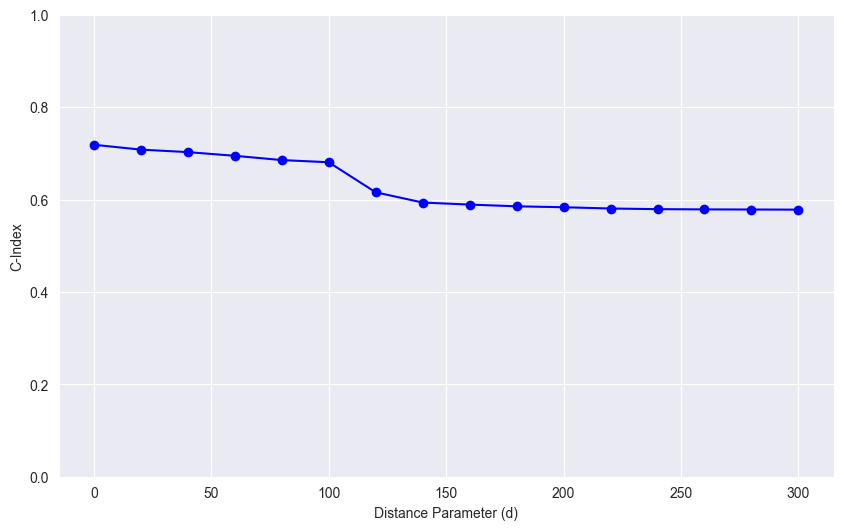

In [45]:
# In this cell, run your script for the Spatial leave-One-Out cross-validation 
# with 9-nearest neighbor regression model and visualize the results as 
# requested in the task assignment.

c_index_values = skcv(X_scaled, y, coords, k, d_values)
print(c_index_values)
plt.figure(figsize=(10, 6))
plt.plot(d_values, c_index_values, marker='o', linestyle='-', color='b')
plt.xlabel('Distance Parameter (d)')
plt.ylabel('C-Index')
plt.ylim(0, 1)
plt.show()

## Analysis of the results

### In this cell, you need to answer the client's questions:


1. What happens to the 9NN performance as the prediction distance increases?
    * **Answer**: The prediction performance starts to degrade as the distance increases.


2. Do you think the results behave as was somewhat expected? Do they make sense, why?
    * **Answer**: Yes, the results are in-line with what we learned about Spatial Autocorrelation (SAC) in the MOOC lectures, meaning that points close to each other resemble each other more than they would points "far" away from them.


3. If we require that the 9NN must have at least C-index performance of 0.68, then up to what distance should we trust the 9NN predictions, based on the results?
    * **Answer**: 100 meters.

## AI usage disclaimer

In case AI was used to solve the exercise, please explain how and in which parts it was used.

Used Cursor's autocomplete in some the cells and sparred with chatgpt about the results.